Code ran under dev branch of Pyro (de4a1cb77e49baf879b1060766527c5dc9c0b63f) and master branch of Pytorch (6420c6b224e943c40952852069e6a006fe88a338)

In [1]:
%pylab inline
from tqdm import tqdm, trange
from collections import defaultdict, namedtuple
import numpy as np
import pymc3 as pm

import torch
import torch.nn as nn
from torch.autograd import Variable

import pyro
import pyro.distributions as dist
from pyro.infer.mcmc.hmc import HMC
from pyro.infer.mcmc.mcmc import MCMC

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pyro.__version__

'0.1.2'

# High-D Gaussian

In [3]:
ndim, num_obs = 10, 100
nchain = 2
mu0 = np.arange(ndim)
data = np.random.randn(num_obs, ndim) + mu0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
100%|██████████| 1000/1000 [00:03<00:00, 311.48it/s]
Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [mu]
100%|██████████| 2000/2000 [00:01<00:00, 1364.81it/s]
The number of effective samples is smaller than 25% for some parameters.


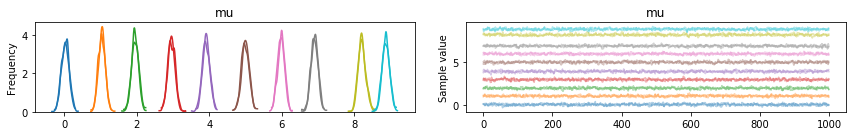

In [4]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 10., shape=ndim)
    obs = pm.Normal('obs', mu, 1., observed=data)
    trace = pm.sample()
    cov = np.atleast_1d(pm.trace_cov(trace))
    step = pm.HamiltonianMC(scaling=np.linalg.inv(cov))
    trace_hmc = pm.sample(1000, tune=1000, step=step, chains=nchain)

pm.traceplot(trace_hmc);

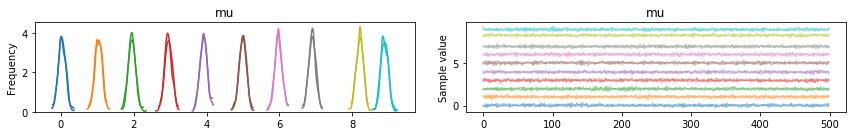

In [5]:
pm.traceplot(trace);

## In Pyro

In [6]:
def m2(data):
    data_ = Variable(torch.Tensor(data))
    mu = pyro.sample('mu', dist.normal,
                         mu=Variable(torch.Tensor(torch.zeros(ndim))), 
                         sigma=Variable(torch.Tensor(torch.ones(ndim)*10)))
    pyro.sample('obs', dist.normal, 
                mu=mu, 
                sigma=Variable(torch.Tensor(torch.ones(ndim))), 
                obs=data_)

In [7]:
draw = 2000
ntune = 1000
n_steps = max(1, int(step.path_length / step.step_size))
hmc_kernel = HMC(m2, step_size=step.step_size, num_steps=n_steps)
mcmc_run = MCMC(hmc_kernel, num_samples=draw, warmup_steps=ntune)

mtrace = []
for i in range(nchain):
    pyro.get_param_store().clear()
    post_pyro = []
    for j, (t, _) in tqdm(enumerate(mcmc_run._traces(data)), total=draw+1):
        post_trace = t.nodes['mu']['value']
        post_pyro.append(post_trace.data.numpy())
    mtrace.append(np.asarray(post_pyro)[ntune+1:])

100%|██████████| 2001/2001 [00:42<00:00, 46.80it/s]


In [8]:
mtrace[0].shape

(1000, 10)

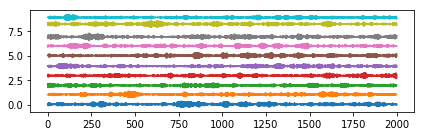

In [9]:
mtrace = np.asarray(mtrace).reshape(nchain*(draw-ntune), ndim, -1).squeeze()
_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(mtrace);
plt.tight_layout();

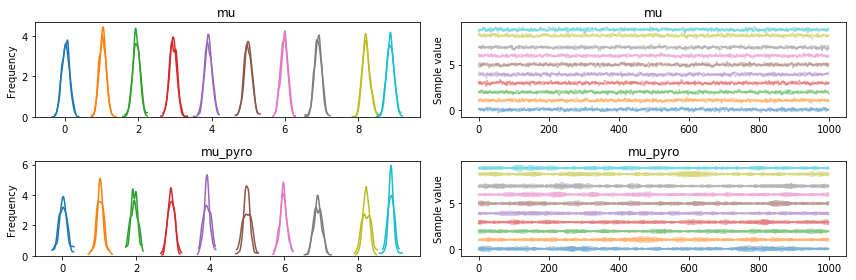

In [10]:
trace_hmc.add_values(dict(mu_pyro=mtrace))
pm.traceplot(trace_hmc);

## Getting logp from pyro

In [34]:
def m2():
    data_ = Variable(torch.Tensor(data))
    mu = pyro.sample('mu', dist.normal,
                         mu=Variable(torch.Tensor(torch.zeros(ndim))), 
                         sigma=Variable(torch.Tensor(torch.ones(ndim)*10)))
    pyro.sample('obs', dist.normal, 
                mu=mu, 
                sigma=Variable(torch.Tensor(torch.ones(ndim))), 
                obs=data_)
hmc_kernel = HMC(m2, step_size=step.step_size, num_steps=n_steps)

In [35]:
hmc_kernel.setup()

In [36]:
hmc_kernel.initial_trace()

In [37]:
trace = hmc_kernel._prototype_trace

In [62]:
z = {name: node['value'] for name, node in trace.iter_stochastic_nodes()}
z

{'mu': Variable containing:
   2.9773
   7.7098
  -3.3626
   2.6209
 -20.8079
   4.4480
   1.3577
  13.5298
   2.0878
 -16.2448
 [torch.FloatTensor of size (10,)]}

In [43]:
trace.log_pdf()

Variable containing:
-72844.1328
[torch.FloatTensor of size (1,)]

In [44]:
z['mu'].numpy()

array([  2.9772937,   7.70978  ,  -3.3626266,   2.6208882, -20.807858 ,
         4.4480085,   1.3577166,  13.529774 ,   2.087762 , -16.244776 ],
      dtype=float32)

In [49]:
from scipy import stats as st
st.norm.logpdf(data, loc=z['mu'].numpy(), scale=1.).sum()

-72806.94998573756

In [50]:
st.norm.logpdf(data, loc=mu0, scale=1.).sum()

-1451.2034684644104

In [42]:
print(hmc_kernel._args, hmc_kernel._kwargs,'/t')

() {} /t


In [51]:
trace.nodes

NodeView(('_RETURN', 'mu', '_INPUT', 'obs'))

In [53]:
trace.nodes['mu']['value']

Variable containing:
  2.9773
  7.7098
 -3.3626
  2.6209
-20.8079
  4.4480
  1.3577
 13.5298
  2.0878
-16.2448
[torch.FloatTensor of size (10,)]

In [59]:
hmc_kernel._get_trace(z).log_pdf()

Variable containing:
-72844.1328
[torch.FloatTensor of size (1,)]

In [67]:
z_next = {key: Variable(torch.Tensor(mu0)) for key, val in z.items()}
z_next

{'mu': Variable containing:
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
 [torch.FloatTensor of size (10,)]}

In [68]:
hmc_kernel._get_trace(z_next).log_pdf()

Variable containing:
-1484.8438
[torch.FloatTensor of size (1,)]

# Chain of Gaussian
adapted from the test case
https://github.com/uber/pyro/blob/7b3a0a833b836c1b7b1e981091b514baec819c40/tests/infer/mcmc/test_hmc.py#L32-L37

Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [mu_4, mu_3, mu_2, mu_1]
100%|██████████| 2000/2000 [00:01<00:00, 1119.99it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


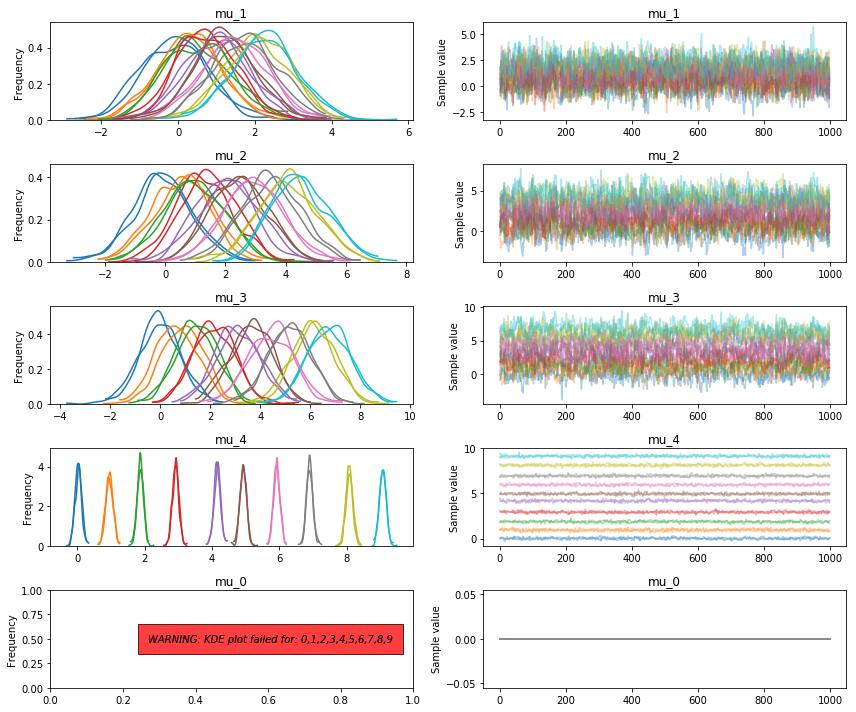

In [11]:
import theano.tensor as tt
import theano

nlayer = 4
with pm.Model() as chain_gaussian:
    mu = pm.Deterministic('mu_0', tt.zeros(ndim))
    for i in range(nlayer):
        mu = pm.Normal('mu_{}'.format(i+1), mu=mu, sd=1., shape=ndim)
    obs = pm.Normal('obs', mu=mu, sd=1., observed=data)
    
    step = pm.HamiltonianMC(step_scale=.01)
    trace_hmc = pm.sample(1000, tune=1000, step=step, chains=nchain)

pm.traceplot(trace_hmc);

In [12]:
import logging
from pyro.distributions.util import torch_ones_like, torch_zeros_like

logging.basicConfig(format='%(levelname)s %(message)s')
logger = logging.getLogger('pyro')
logger.setLevel(logging.INFO)

class GaussianChain(object):

    def __init__(self, dim, chain_len):
        self.dim = dim
        self.chain_len = chain_len
        self.mu_0 = Variable(torch_zeros_like(torch.Tensor(self.dim)), requires_grad=True)
        self.lambda_prec = Variable(torch_ones_like(torch.Tensor(self.dim)))

    def model(self, data):
        mu = pyro.param('mu_0', self.mu_0)
        lambda_prec = self.lambda_prec
        for i in range(1, self.chain_len + 1):
            mu = pyro.sample('mu_{}'.format(i), dist.normal, mu=mu, sigma=Variable(lambda_prec.data))
        pyro.sample('obs', dist.normal, mu=mu, sigma=Variable(lambda_prec.data), obs=data)


fixture = GaussianChain(dim=ndim, chain_len=nlayer)
num_samples=1000
warmup_steps=300
hmc_params={'step_size': 0.165,
            'num_steps': 5}

hmc_kernel = HMC(fixture.model, **hmc_params)
mcmc_run = MCMC(hmc_kernel, num_samples, warmup_steps)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

data_ = Variable(torch.Tensor(data))
for t, _ in mcmc_run._traces(data_):
    for i in range(nlayer + 1):
        param_name = 'mu_' + str(i)
        post_trace[param_name].append(t.nodes[param_name]['value'])

INFO Starting MCMC using kernel - HMC ...
INFO Iteration: 65.
INFO Acceptance rate: 0.9076923076923077
INFO Iteration: 130.
INFO Acceptance rate: 0.7692307692307693
INFO Iteration: 195.
INFO Acceptance rate: 0.6564102564102564
INFO Iteration: 260.
INFO Acceptance rate: 0.6115384615384616
INFO Iteration: 325.
INFO Acceptance rate: 0.563076923076923
INFO Iteration: 390.
INFO Acceptance rate: 0.5512820512820513
INFO Iteration: 455.
INFO Acceptance rate: 0.5626373626373626
INFO Iteration: 520.
INFO Acceptance rate: 0.5634615384615385
INFO Iteration: 585.
INFO Acceptance rate: 0.5623931623931624
INFO Iteration: 650.
INFO Acceptance rate: 0.5553846153846154
INFO Iteration: 715.
INFO Acceptance rate: 0.5552447552447553
INFO Iteration: 780.
INFO Acceptance rate: 0.5602564102564103
INFO Iteration: 845.
INFO Acceptance rate: 0.5491124260355029
INFO Iteration: 910.
INFO Acceptance rate: 0.5505494505494506
INFO Iteration: 975.
INFO Acceptance rate: 0.5374358974358975
INFO Iteration: 1040.
INFO Acc

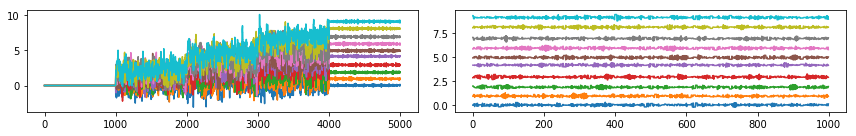

In [13]:
post_pyro = []
for i in range(nlayer+1):
    param_name = 'mu_' + str(i)
    ichain = torch.stack(post_trace[param_name])
    post_pyro.append(ichain.data.numpy()[:1000,:,np.newaxis])

post_pyro = np.asarray(post_pyro).reshape([(nlayer+1)*1000, ndim])

_, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].plot(post_pyro.squeeze());
ax[1].plot(post_pyro[4000:, :].squeeze())
plt.tight_layout();

In [14]:
def chain_gaussian2(data):
    data_ = Variable(torch.Tensor(data))
    mu = pyro.param('mu_0', Variable(torch.zeros(ndim), requires_grad=True))
    for i in range(nlayer):
        mu = pyro.sample('mu_{}'.format(i+1), dist.normal,
                         mu=mu, 
                         sigma=Variable(torch.ones(ndim)))
    pyro.sample('obs', dist.normal, 
                mu=mu, 
                sigma=Variable(torch.ones(ndim)), 
                obs=data_)
    
draw = 2000
ntune = 1000
hmc_params={'step_size': 0.165,
            'num_steps': 5}

hmc_kernel = HMC(chain_gaussian2, **hmc_params)
mcmc_run = MCMC(hmc_kernel, draw, ntune)
pyro.get_param_store().clear()
post_trace = defaultdict(list)

for t, _ in mcmc_run._traces(data):
    for i in range(nlayer + 1):
        param_name = 'mu_' + str(i)
        post_trace[param_name].append(t.nodes[param_name]['value'])

INFO Starting MCMC using kernel - HMC ...
INFO Iteration: 150.
INFO Acceptance rate: 0.74
INFO Iteration: 300.
INFO Acceptance rate: 0.6266666666666667
INFO Iteration: 450.
INFO Acceptance rate: 0.6111111111111112
INFO Iteration: 600.
INFO Acceptance rate: 0.6
INFO Iteration: 750.
INFO Acceptance rate: 0.588
INFO Iteration: 900.
INFO Acceptance rate: 0.56
INFO Iteration: 1050.
INFO Acceptance rate: 0.5457142857142857
INFO Iteration: 1200.
INFO Acceptance rate: 0.5425
INFO Iteration: 1350.
INFO Acceptance rate: 0.5392592592592592
INFO Iteration: 1500.
INFO Acceptance rate: 0.534
INFO Iteration: 1650.
INFO Acceptance rate: 0.5375757575757576
INFO Iteration: 1800.
INFO Acceptance rate: 0.54
INFO Iteration: 1950.
INFO Acceptance rate: 0.5420512820512821
INFO Iteration: 2100.
INFO Acceptance rate: 0.5414285714285715
INFO Iteration: 2250.
INFO Acceptance rate: 0.5444444444444444
INFO Iteration: 2400.
INFO Acceptance rate: 0.5433333333333333
INFO Iteration: 2550.
INFO Acceptance rate: 0.53882

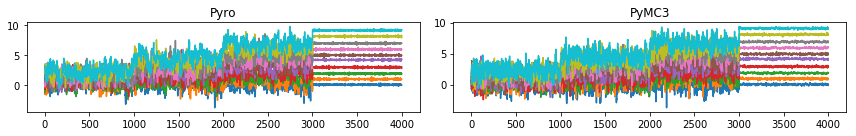

In [15]:
post_pyro = []
post_pymc = []
for i in range(1, nlayer+1):
    param_name = 'mu_' + str(i)
    ichain = torch.stack(post_trace[param_name])
    post_pyro.append(ichain.data.numpy()[:1000,:,np.newaxis])
    post_pymc.append(trace_hmc[param_name][:1000])
    
post_pyro = np.asarray(post_pyro).reshape([(nlayer)*1000, ndim])
post_pymc = np.asarray(post_pymc).reshape([(nlayer)*1000, ndim])

_, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].plot(post_pyro.squeeze());
ax[0].set_title('Pyro')

ax[1].plot(post_pymc.squeeze())
ax[1].set_title('PyMC3')

plt.tight_layout();

# Gaussian with sigma

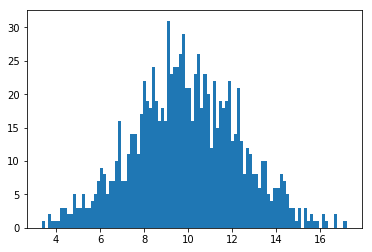

In [16]:
mu0, sigma = 10., 2.4
N = 1000
X = mu0 + np.random.randn(N, 1)*sigma

plt.hist(X, 100);

In [17]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    sd = pm.HalfCauchy('sd', 2.5)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=X)
    trace = pm.sample()
    cov = np.atleast_1d(pm.trace_cov(trace))
    step = pm.HamiltonianMC(scaling=np.linalg.inv(cov))
    trace_hmc = pm.sample(1000, tune=1000, step=step)

Auto-assigning NUTS sampler...
INFO Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, mu]
INFO NUTS: [sd_log__, mu]
100%|██████████| 1000/1000 [00:02<00:00, 435.10it/s]
Multiprocess sampling (2 chains in 2 jobs)
INFO Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [sd_log__, mu]
INFO HamiltonianMC: [sd_log__, mu]
100%|██████████| 2000/2000 [00:03<00:00, 560.76it/s]
The acceptance probability does not match the target. It is 0.878860223079689, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING The acceptance probability does not match the target. It is 0.878860223079689, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR The estimated number of effective sampl

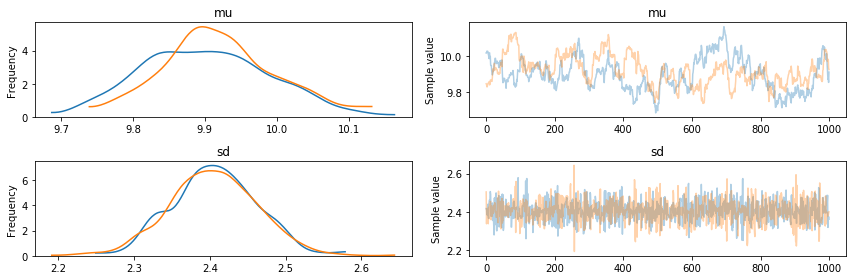

In [18]:
pm.traceplot(trace_hmc);

In [19]:
ndim = 1
def m2(data):
    data_ = Variable(torch.Tensor(data))
    mu = pyro.sample('mu', dist.normal,
                     mu=Variable(torch.Tensor(torch.zeros(ndim))),
                     sigma=Variable(torch.Tensor(torch.ones(ndim)*10)))
    sd = pyro.sample('sd', dist.halfcauchy,
                     mu=Variable(torch.Tensor(torch.ones(ndim)*2)),
                     gamma=Variable(torch.Tensor(torch.ones(ndim)*2)))
    pyro.sample('obs', dist.normal, 
                mu=mu, 
                sigma=sd, 
                obs=data_)

In [23]:
n_steps = max(1, int(step.path_length / step.step_size))

hmc_params={'step_size': step.step_size,
            'num_steps': n_steps}
hmc_kernel = HMC(m2, **hmc_params)
mcmc_run = MCMC(hmc_kernel, num_samples=2000, warmup_steps=1000)

post_trace = defaultdict(list)

for t, _ in mcmc_run._traces(data):
    for i in range(nlayer + 1):
        param_name = 'mu_' + str(i)
        post_trace[param_name].append(t.nodes[param_name]['value'])

ValueError: Found non-reparameterized node in the model at site: sd

# Regression

In [ ]:
def m2(X, Y):
    X, Y = Variable(torch.Tensor(X)), Variable(torch.Tensor(Y))
    mu = pyro.sample("mu", dist.normal, Variable(torch.Tensor([0]*N)),
                                        Variable(torch.Tensor([100]*N)))
    b = pyro.sample("b", dist.normal, Variable(torch.Tensor([0]*N)),
                                      Variable(torch.Tensor([10]*N)))
    yhat = mu + X * b
    sd = pyro.sample("sigma", dist.normal, Variable(torch.Tensor([0])), 
                                           Variable(torch.Tensor([2.5])))
    sd_ = sd**2
    return pyro.sample("height", dist.normal, yhat, (sd_).expand_as(mu), obs=Y.squeeze())

In [ ]:
beta = [7., 3.4]
sigma = 2.1
N = 100
X = np.random.randn(N, 1)
Y = beta[0] + beta[1]*X + np.random.randn(N, 1)*sigma

plt.plot(X, Y, 'o');

In [ ]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    b = pm.Normal('b', 0., 10.)
    sd = pm.HalfCauchy('sd', 2.5)
    obs = pm.Normal('obs', mu=mu+X*b, sd=sd, observed=Y)
    trace = pm.sample()

In [ ]:
pm.traceplot(trace);

In [ ]:
with m:
    cov = np.atleast_1d(pm.trace_cov(trace))
    step = pm.HamiltonianMC(scaling=np.linalg.inv(cov))
    trace_hmc = pm.sample(1000, tune=1000, step=step)

In [ ]:
pm.traceplot(trace_hmc);

In [ ]:
mu